# The Project <a class="anchor" id="t1"></a>

One year ago we embark on a new project in Mad Flow. It continues the roadmap of the company to improve the quality of life in Madrid. The objective was to forecast the traffic in the city and to show it in an interface in real time so that citizens can better plan their route. Traffic analysis has become an indispensable task in smart cities. Having a better knowledge of the traffic allows a better organization and governance of the roads. 

In addition, we studied the possibility of including other data such as precipitation or temperature  for better predictions. The data provided by sensors in smart cities are usually heterogeneous. In the case of the city of Madrid in Spain, there are climatic and traffic data that cover the entire center of the city but they were difficult to integrate and need a complex infrastucuture.

Testing the model we found an important performance limitation. The infrastructure was slow and unwieldy when incorporating new traffic data-sets or building new insights quickly what is essential in the project. To move forward with the project, a change in implementation was necessary.

We found a solution to our problem: Kdb+/q by KX. This platform is extremely fast and flexible and allows data processing in real time. It also has PyKX, an open-source library that is designed to be friendly with Python programmers (essential in Mad Flow).

In this technical report we present how the migration of the code to the KX platforms was carried out. But first we'll talk about the use case and the project status.

<div class="alert alert-block alert-info">
<b> 🔍 You can find <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">Original Python Project</a> in Github. 
</div>

**Index**

[**The project**](#t1)   
  [**The Use Case**](#t11)   
  [**The Data**](#t12)   
  [**The Cleaning**](#t13)   
  [**The Final Table**](#t14)   
  [**The Interpretation**](#t15)   
[**PyKX migration:** ](#ID2)   
  [**PyKX saving the day!**](#t12)   
  [**Datasets**](#t13)   
  [**Model**](#t14)   
[**Q Migration:**](#ID2)   
  [**Qholic**](#t12)   
  [**Datasets**](#t13)   
  [**Model**](#t14)    


## The Use Case <a class="anchor" id="t11"></a>

The objective of the code is to prepare and join the traffic and weather data to be ingested by an LSTM model.

Although this project is novel in the city of Madrid, there are many articles that support it. For example, [F. Malik et al.](https://www.mdpi.com/1424-8220/20/13/3749) forecasted traffic in Madrid based on air pollution through a model based on LSTM.

On the dependence of the weather on traffic there are many studies, especially focused on rainfall. None of the studies are carried out in Madrid, but in several large cities such as Manchester ([A. Essien et al.](https://pure.manchester.ac.uk/ws/portalfiles/portal/72721911/DEXA_Camera_8_pages.pdf)), Shenzhen ([Y. Yao et al.](https://ieeexplore.ieee.org/document/8964560)), Belgrade ([M. Vidas et al.](https://www.safetylit.org/citations/index.php?fuseaction=citations.viewdetails&citationIds[]=citjournalarticle_716898_14)). The results of these studies predict a 5-15% increase in traffic volume on weekdays during peak hours.

## The Data <a class="anchor" id="t12"></a>

Madrid weather and traffic data are offered by the [Madrid City Council](https://datos.madrid.es/portal/site/egob). These datasets include live and historical records. For model ingestion we only need the historical data. This data, which is in csv format, is divided into months from the year 2018 to the present.

**Weather**

[Weather data](https://datos.madrid.es/portal/site/egob/menuitem.3efdb29b813ad8241e830cc2a8a409a0/?vgnextoid=4950cc720ba29610VgnVCM2000001f4a900aRCRD&vgnextchannel=102612b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)  is captured by stations located throughout the city of Madrid. It looks like the following table:

|    |   weather_station |   magnitud |   year |   month |   day |    H01 | V01   | ...|
|---:|------------------:|-----------:|-------:|--------:|------:|-------:|------:|:------|
|  0 |               108 |         81 |   2022 |      12 |    22 |  270   | N     | ...|
|  1 |               108 |         82 |   2022 |      12 |    22 |    9   | N     |...|
|  2 |               108 |         83 |   2022 |      12 |    22 |   94.7 | N     |...|
|  3 |               108 |         86 |   2022 |      12 |    22 | 1031   | N     |...|
|  4 |               108 |         87 |   2022 |      12 |    22 |    2   | N     |...|


In the documentation they tell us that the magnitude column indicates what type of meteorological data has been taken in the row:

    · 80: ultraviolet
    · 81: wind
    · 82: direction
    · 83: temperature
    · 86: humidity
    · 87: pressure
    · 88: solar
    · 89: rainfall
    
Then we have two columns for each hour so that the first tells us the value for the data type specified by the magnitude column and if the result is valid or not. We also have columns related to the time in which the measurement is taken. Finally, there is the identifier of the meteorological station which we can connect with its coordinates using this other [table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=2ac5be53b4d2b610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) provided by the Madrid city council:

|    |   weather_station |   Longitude |   Latitude |
|---:|------------------:|------------:|-----------:|
|  0 |                 4 |    -3.71226 |    40.4239 |
|  1 |                 8 |    -3.68232 |    40.4216 |
|  2 |                16 |    -3.63924 |    40.44   |
|  3 |                18 |    -3.73184 |    40.3948 |
|  4 |                24 |    -3.74734 |    40.4194 |

**Traffic**

Traffic sensors are located at traffic lights in the city of Madrid. The data obtained is made up of several measurements of the road situation such as speed or traffic volume. All of these metrics are coded into the "load" metric (a percentage that measures congestion). The [traffic table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=02f2c23866b93410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD) head is:

|    |   traffic_station | tipo_elem   |   intensidad |   ocupacion |   load |   vmed | error   |   periodo_integracion | date                |
|---:|------------------:|:------------|-------------:|------------:|-------:|-------:|:--------|----------------------:|:--------------------|
|  0 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:00:00 |
|  1 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:15:00 |
|  2 |              1001 | M30         |          300 |           1 |      0 |     66 | N       |                     5 | 2022-12-01 00:30:00 |


The table also contains a column for the date and another that identifies the sensor that will be used to link it with its coordinates using the following [table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=ee941ce6ba6d3410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD):

|    | "tipo_elem"   |   "distrito" |   "id" | "cod_cent"   | "nombre"                                                          |   "utm_x" |     "utm_y" |   Longitude |   Latitude |
|---:|:--------------|-------------:|-------:|:-------------|:------------------------------------------------------------------|----------:|------------:|------------:|-----------:|
|  0 | "URB"         |            4 |   3840 | "01001"      | "Jose Ortega y Gasset E-O - Pº Castellana-Serrano"                |    441615 | 4.47577e+06 |    -3.68832 |    40.4305 |
|  1 | "URB"         |            4 |   3841 | "01002"      | "Jose Ortega y Gasset O-E - Serrano-Pº Castellana"                |    441706 | 4.47577e+06 |    -3.68726 |    40.4305 |
|  2 | "URB"         |            1 |   3842 | "01003"      | "Pº Recoletos N-S - Almirante-Prim"                               |    441319 | 4.47484e+06 |    -3.69173 |    40.4221 |

## The Cleaning  <a class="anchor" id="t13"></a>

Once the data has been loaded, we prepared the data to be used in the analysis and the model. As we are dealing with heterogeneous datasets, the cleaning of the data will be done independently and the data will be assembled a single table later.

#### Weather

1. In the weather dataset we have the date separated into day, month and year, but in traffic all these data are together. This is why the columns have been grouped into a date column of shape: ```day-month-year```. 

2. We also transform each hour value measurement and its validity into independent rows and we take the opportunity to remove invalid measurements:

|       | hour            |   value |
|------:|:----------------|--------:|
|     0 | 0 days 00:00:00 |    7.1  |
|     1 | 0 days 00:00:00 |    6.8  |
|     2 | 0 days 00:00:00 |    2.8  |
|     3 | 0 days 00:00:00 |    5.6  |

3. To homogenize the time measure with the traffic table we join the date with the time. The new date shape is ```date-month-year hour:minute:second```

4. Finally, to have more organized data, we convert the different types of measurement into columns:

|      | date                |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |
|-----:|:--------------------|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|
|    0 | 2022-12-01 00:00:00 |                 4 |           0 |          0 |          0 |        0   |       0 |           7.1 |   0    |
|    1 | 2022-12-01 00:00:00 |                 8 |           0 |         67 |          0 |        0   |       0 |           9.4 |   0    |
|    2 | 2022-12-01 00:00:00 |                16 |           0 |         73 |          0 |        0   |       0 |           8.9 |   0    |

#### Traffic

1. The rows where the data collection has had an error are eliminated, for this we filter the values without measurement errors. In the documentation they tell us that these values are represented with an "N". 

2. We only keep the load measurement, which is what we are interested in for the analysis.

3. We group the values for each date and station and calculate the average.

The average time for loading and processing a month of traffic information is **43.9 s**. The team is concerned about the slowness and the possible effect it will have on real-time data processing.

**Location**

To join the two previous tables we need to know which traffic sensors correspond to the weather stations. To do this you can use a distance matrix and find the closest pairs. You could measure this distance directly with the coordinates. But to make the distances clearer, the Haversine distance was used, which calculates the distance in meters between a pair of coordinates. It can be seen in the next heatmap that these distances are between 0 and 20 km:

<figure>
<img src="files/image_source/heatmap3.png">
<figcaption style = "text-align: center"> <b>Figure 1:</b> Heatmap of distances in km between weather and traffic stations </figcaption>
</figure>

## The Final Table <a class="anchor" id="t14"></a>

Once we have prepared the 3 tables -weather, traffic and distance- we put them together. Since the weather table has time intervals of 1 hour while the traffic ones have 15 minutes, we will join both tables with an asof join. And, finally, we can add the information of the time and the day of the week to study its dependence on the traffic load.

|    | date                |   traffic_station |   load |   Distance |   Closest |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |   weekday |   hour |
|---:|:--------------------|------------------:|-------:|-----------:|----------:|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|----------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |         14 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |         14 |         0 |                 4 |           0 |          0 |          0 |          0 |       0 |           7.1 |      0 |         3 |      0 |

## Data interpretation <a class="anchor" id="t15"></a>

Several studies were carried out to find out what time variables could be interesting to add to the model. In the first place, since traffic is so dependent on time, the measurements will be filtered to obtain the days of the week and the hours where there is usually more traffic. This will make it easier for the test model to learn. School days tend to have more traffic than holidays. Just as there is usually more traffic during the day than at night. In the following figure we can verify that the data have a strong seasonality:

<table>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="files/image_source/loadperhour.png">
<figcaption style = "text-align: center">   <b>Figure 2:</b> Load per Hour </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="files/image_source/loadperweekday.png">
<figcaption style = "text-align: center">   <b>Figure 3:</b> Load per Weekday </figcaption>
</figure>
            </td>
    </tr>
</table>

We keep the data between 10 a.m. and 8 p.m., from Monday to Friday, for the rest of the project.

Regarding the Rainfall-Load dependency ee started seeing that rainy days are very few:

|       |       rainfall |
|:------|---------------:|
| count | 841068         |
| mean  |      0.0130932 |
| std   |      0.194232  |
| min   |      0         |
| 50%   |      0         |
| 90%   |      0         |
| 99.9% |      2.9       |
| max   |     10.9       |

We can see in the percentiles of the precipitation column that there are very few recordings with rain. This is why the measurements were divided into different classes depending on the level of rain and we did a separate analysis for the data with heavy rain, moderate to moderate and no rain. The analysis was done hourly to avoid the temporal dependence of the load. We can verify this in the following table, where the average increase in hours of traffic congestion with rain can go from 5% to 14%, which agrees with the studies presented in [The Use Case](#t12).

<figure>
<img src="files/image_source/rainfall.png">
<figcaption style = "text-align: center"> <b>Figure 4:</b> The average traffic load per hour for the measurements with heavy rain (blue), moderate rain (brown) and no rain (green).</figcaption>
</figure>

To verify that these differences between groups are significant, we can do an anova test. And we see that in all hours there is great evidence that the load is different between the different types of rain. For example, for hour 12:

|             |          sum_sq |    df |        F |       PR(>F) |
|:------------|----------------:|------:|---------:|-------------:|
| C(rainfall) | 37650.7         |     6 |  20.1144 |   1.3346e-23 |
| Residual    |     8.01363e+06 | 25687 | nan      | nan          |

It was decided to include precipitation within the model. The rest of the meteorological conditions did not give such a clear result, so they will be left out.

## Month 6:  The Model <a class="anchor" id="t16"></a>

To check the performance we created a toy model using a simple LSTM with 5 steps back to forecast the load at a single station. The input includes only the 5 steps prior to the prediction of the load, the rain, the time and the day of the week. The results for a single station seem quite positive as can be seen in [Graph 6](#Image61). But the temporary cost for a single station and a single month is unaffordable for the project budget. Also, the pre-processing takes too long for the final application in real time.

<table> <a class="anchor" id="Image61"></a>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="files/image_source/loss_graph_p.png">
<figcaption style = "text-align: center">   <b>Figure 5:</b> Train vs Test loss plot  </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="files/image_source/fc_p.png">
<figcaption style = "text-align: center">   <b>Figure 6:</b> Traffic Forecasting for a traffic station </figcaption>
</figure>
            </td>
    </tr>
</table>


# PyKX migration

Once the project is clear, we will explain the steps that have been taken for the migration, which include a training stage in q and pykx of the team, the datasets loading and cleaning and the model ingestion. But first of all we need to install and import PyKx:

In [ ]:
!pip install pykx

In [20]:
import pykx as kx

<div class="alert alert-block alert-info">
<b> 🔍 A license is required to use some of the following features. You can find more information in <a href="https://code.kx.com/pykx/1.6/getting-started/installing.html">
            PyKX installation documentation</a>. 
</div>

[]()

## Learning PyKX 

Before starting the project, the Mad Flow team received training from [Habla Computing](https://hablapps.com/) on q and PyKX. After this introduction to KX platforms, some of the developers fell in love with q, while others felt more comfortable in the Python ecosystem. PyKX is designed so that these two profiles coexist in the same development environment. The team has made a compilation of perspectives, some more pythonic and others more qtonic, with which they feel more comfortable programming:

* **[Useful Read/Write Functions](https://code.kx.com/pykx/1.6/api/read.html)**

>*"PyKX offers several functions that help loading and writing data, they are very versatile and the parameters are very intuitive."*

In [21]:
traffic_station = kx.q.read.csv('./pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

* **[Use pythonic indexing](https://code.kx.com/pykx/1.6/user-guide/fundamentals/indexing.html)**

> *"Accessing data from q objects such as lists or tables from python can be done with indexing similar to what you can use in numpy or pandas. This has made my job much easier."*

In [22]:
elem = traffic_station["tipo_elem"]
lat = traffic_station["latitud"]
print(lat[:5])

40.4305 40.43052 40.42213 40.42143 40.43378


* **[Use q functions]()**

> *"For those like me who want to delve into the q language and gain experience, you can use language functions, ...*

In [76]:
distinct = kx.q("distinct", elem) # unique values in the list
print(distinct) 

`URB`other`M30


> *... iterate over them ...*

In [77]:
print(kx.q("lower").each(distinct)) # lower case unique values of the list

`urb`other`m30


>*... or even create and use them with pykx objects."*

In [68]:
print(kx.q("{u !(sum x=) each u:distinct x}", elem)) # Count the occurrences of distinct values

URB  | 4266
other| 128
M30  | 296


* **Use [Numpy](https://code.kx.com/pykx/1.6/user-guide/advanced/numpy.html) and  [Pandas](https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html)**

> *"Those of us who are not yet so familiar with the ecosystem that we can continue using part of the functionality of Numpy...*

In [24]:
import numpy as np
np.mean(lat)

40.42870774510621

>*... and from pandas via the Pandas API."*

In [64]:
import os
os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
import pykx as kx
import numpy as np
import pandas as pd

print(traffic_station[traffic_station["tipo_elem"]=="other"][:5]) # filter rows where the values of a column meet a condition

tipo_elem distrito id   cod_cent nombre                                      ..
-----------------------------------------------------------------------------..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..



<div class="alert alert-block alert-info">
<b>To use it we only have to import numpy and pandas and activate a flag. Pandas API is still in the development phase, so it does not yet have all the functions of Pandas. More information in <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html"> Pandas API </a> . 
</div>
    
    


* **Use [qSQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

> *"SQL queries are very powerful and concise at the same time. PyKX allows you to query PyKX objects as well as API functions...* 

In [83]:
print(kx.q.qsql.select(traffic_station, {"name":"5 # nombre"}, where="tipo_elem = `other")) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


> *...or using our own functions q."*

In [82]:
print(kx.q("{select name:5#nombre from x where tipo_elem = `other}", traffic_station)) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


* **Use [SQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

>*"Whoa! PyKx lets you use SQL queries too!"*

In [ ]:
kx.q.sql("select top 5 nombre from $1 where tipo_elem=`other", traffic_station)

* **Q Context**

> *"I'm more comfortable programming in q, so I work in the context of q. PYKX objects can be passed into the q context and work with them as if you were in a q ecosystem:"*

In [81]:
kx.q["traffic_station"] = traffic_station # Move Pykx Object to Q Context

print(kx.q("select name:5#nombre from traffic_station where tipo_elem = `other")) # Working with the table inside q

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


* **Python/Q Transform**

> *"I'm new to the project and still have to catch up with q. In the meantime I can pass the objects from q to pandas...*

In [124]:
traffic_station.pd().head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud
0,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
1,URB,4,3841,b'01002',b'Jose Ortega y Gasset O-E - Serrano-P\xc2\xba...,441705.882340,4.475770e+06,-3.687256,40.430524
2,URB,1,3842,b'01003',b'P\xc2\xba Recoletos N-S - Almirante-Prim',441319.371258,4.474841e+06,-3.691727,40.422132
3,URB,4,3843,b'01004',b'P\xc2\xba Recoletos S-N - Pl. Cibeles- Recol...,441301.632986,4.474764e+06,-3.691929,40.421433
4,URB,4,3844,b'01005',b'(AFOROS) P\xc2\xba Castellana S-N - Eduardo...,441605.765072,4.476132e+06,-3.688470,40.433782


>*... numpy, ...*

In [128]:
lat.np()[:5]

array([40.43050187, 40.43052394, 40.42213209, 40.42143334, 40.43378206])

> *... and python to work on ...*

In [127]:
lat.py()[:5]

[40.4305018691825,
 40.4305239406404,
 40.4221320929972,
 40.4214333442836,
 40.4337820578943]

>*... and then back to q so that colleagues can continue the work."*

In [130]:
kx.toq(lat.py())

pykx.FloatVector(pykx.q('40.4305 40.43052 40.42213 40.42143 40.43378 40.42351 40.42816 40.42879 40.426..'))

During the development of the project some of these methods will be described in depth. The best thing is that they are fully compatible with each other, so developers can choose the one that is most comfortable for them!

## Datasets

### Weather

The data load will be done with the utility provided by [pykx for load files](https://code.kx.com/pykx/1.4/api/read.html):

In [23]:
weather = kx.q.read.csv('./dic_meteo22.csv', types='I'*4 + '*'*4 + 'FS'*24, delimiter=';')

Los parámetros de esta función son bastante estándares en los cuales se indica la url al fichero y el delimitador. Destacamos el parámetro *types* que espera los [tipos](https://code.kx.com/q/basics/datatypes/) de cada columna. Nuestras tablas son objetos pykx:

In [71]:
type(weather)

pykx.wrappers.Table

Pero no está en el contexto de q. Veamos como acceder a estos objetos y como utilizar funcionalidades de q sobre ellos. Empecemos con la sencilla función de *xcol*, que nos permite cambiar el nombre de las columnas:

In [24]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)

We see that this function is overloaded in PyKX. Many q functions are available through the pykx.q interface. Los atributos son idénticos a los que se esperan en la función de q pero con estructuras de Python. Estas funciones vienen recopiladas y perfectamente explicadas en la [documentación de pykx](https://code.kx.com/pykx/1.6/api/q/q.html). 

Apart from this functions we have the kx.q.qsql interface, which allows us to query into tables. Specifically we used `select`, `update` and `delete`, which share some common characteristics, mainly with the arguments they receive.

Both `select` and `update` share more or less this function call structure:

`kx.q.sql.{function}({tab}, columns=..., where=..., by=...)`

The `columns` argument expects either a list of strings or a dictionary where the key is the column name and the value is the actual value you want in this column if let's say you want to apply a function to it. Let's look at this specific example:

In [25]:
weather = kx.q.qsql.delete(weather, ['PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

Con el código anterior hemos eliminado varias columnas que no son relevantes para el análisis.

La siguiente tarea que debemos realizar es combinar el año, el mes y el día a una única columna fecha. Para ello se comienza accediendo a estas tres columnas. Esto se puede hacer mediante indexación:

In [26]:
weather["year", "month", "day"]

pykx.List(pykx.q('
"2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" ..
"12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   ..
"22"   "22"   "22"   "22"   "22"   "22"   "22"   "01"   "02"   "03"   "04"   ..
'))

Vemos que el resultado son tres listas del tamaño de la muestra. Nuestro objetivo es una lista de tamaño de la muestra con los tres elementos que forman la fecha unidos:

In [27]:
kx.q.flip(weather["year", "month", "day"])[:3]

pykx.List(pykx.q('
"2022" "12" "22"
"2022" "12" "22"
"2022" "12" "22"
'))

Parece que nos acercamos ahora tenemos una lista del tamaño de la muestra con una lista en cada posción que contiene 3 elementos: el día, el mes y el año. Para juntar cada conjunto de la lista en un único elemento unido se utilizará el iterador *each*:

In [28]:
kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))[:3]

pykx.List(pykx.q('
"20221222"
"20221222"
"20221222"
'))

Parece que ya estamos bastante cerca. Solo nos hace falta convertir el tipo de dato de string a fecha.  Desafortunadamente, some functions (especially the overloaded glyphs) are not implemented. For example cast (`$`), take (`#`), concat (`,`)... Por lo que nos vemos obligados a abandonar pykx y llevar a cabo este casting en q:

In [29]:
date = kx.q('"D"$',(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))))
date[:3]

pykx.DateVector(pykx.q('2022.12.22 2022.12.22 2022.12.22'))

Solo nos queda añadir esta columna a nuestra tabla:

In [30]:
weather_ = kx.q.qsql.update(weather, columns = {'date': date})

Pudimos comprobar que aunque se tuviesen que utilizar funciones q en vez de funciones pykx, no había sido algo verdaderamente costoso y la solución era más conciso. Una vez el equipo tuvo algo más de soltura se propuso una función enteramente en q mucho más concisa:

In [31]:
weather = kx.q.qsql.update(weather, columns = {'date':'"D"$ raze each flip(year;month;day)'})

De nuevo, ambas soluciones son enteramente compatibles, incluso combinables, queda a gusto del programador el uso de una u otra metodología. Por último, podemos eliminar las tres columnas que ya están incluidas en fecha:

In [32]:
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day'])

Veamos cual es el estado actual de la tabla weather:

In [80]:
weather[:3].pd()

,weather_station,magnitude,H01,V01,H02,V02,H03,V03,H04,V04,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,date
0,108,81,270.0,N,252.0,N,216.0,N,242.0,N,...,V,228.0,V,227.83,V,213.67,V,233.83,V,2022-12-22
1,108,82,9.0,N,8.0,N,9.0,N,8.0,N,...,V,10.0,V,9.00,V,9.00,V,8.00,V,2022-12-22
2,108,83,94.7,N,97.6,N,96.6,N,97.5,N,...,V,91.4,V,93.80,V,96.30,V,98.70,V,2022-12-22


It is time to turn our attention into breaking down the H* and V* queries into multiple rows, and supplying a time column to avoid missing information. La forma de proceder en q sería utilizar qsql funcional para seleccionar las columnas que sigan los patrones anteriores, pero vamos a aprovechar que el código q en pykx se introduce a través de Strings para evitarlo:

In [33]:
def functionalSearch(cols, pattern, func):
  xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
  xstring = func.format(kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8"))
  return xcols, xstring

La anterior función recibe una lista de columnas, un patrón a buscar y una función q en formato string que introduce como argumento las columnas encontradas siguiendo ese patrón en el formato de qSQL (donde a las columnas se accede con su nombre y no con un símbolo). Al aplicar esto a todas las columnas que empiezan por *"H"* se nos devuelven estas columnas como un vector de Symbols y en un String estas columnas en formato de qSQL: 

In [9]:
cols = kx.q.cols(weather)
found_columns, qsql_function = functionalSearch(cols, b'H*', "{}")

print("Columns found: ", found_columns)
print("Qsql function: ", qsql_function)

Columns found:  `H01`H02`H03`H04`H05`H06`H07`H08`H09`H10`H11`H12`H13`H14`H15`H16`H17`H18`H19`..
Qsql function:  H01;H02;H03;H04;H05;H06;H07;H08;H09;H10;H11;H12;H13;H14;H15;H16;H17;H18;H19;H20;H21;H22;H23;H24


Utilicemos lo anterior para las columnas que empiezan H, las cuales nos dará el valor de la medición; y la columnas que empiezan por V, las cuales nos dicen si la medición es válida. La función que debemos utilizar para que las mediciones en formato columna se vuelvan filas es *flip*:

In [34]:
hcols, value = functionalSearch(cols, b'H*', "flip({})")
vcols, valid = functionalSearch(cols, b'V*', "flip({})")

Ahora solo tenemos que pasar nuestras funciones prefabricadas en formato String a la función de qSQL *"update"*, junto a las 24 horas repetidas el número de filas inicial:

In [35]:
weather = kx.q.qsql.update(weather, columns = {'hour': 'count[i]#enlist 01:00*til 24', 'values': value, 'valid': valid})

Ahora podemos eliminar las columnas que hemos utilizado, de nuevo utilizando el truco para evitar qSQL funcional:

In [36]:
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py())

Veamos el resultado:

In [47]:
weather[:3].pd()

,weather_station,magnitude,date,hour,value,valid
0,108,81,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[270.0, 252.0, 216.0, 242.0, 239.0, 246.0, 233...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
1,108,82,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
2,108,83,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[94.7, 97.6, 96.6, 97.5, 97.5, 98.2, 98.8, 98....","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."


Ahora no hay más que expandir la tabla para que cada fila corresponda a una hora:

In [37]:
weather = kx.q.ungroup(weather)

Podemos contraer un poco más la tabla eliminado las filas que no son válidas y uniendo la fecha con la hora:

In [38]:
weather = kx.q.qsql.select(weather, where = 'valid=`V')
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = ["valid", "hour"])
weather[:3].pd()

,weather_station,magnitude,date,values
0,108,81,2022-12-22 10:00:00,263.00
1,108,81,2022-12-22 11:00:00,247.83
2,108,81,2022-12-22 12:00:00,215.83


The **magnitude** column is required to give semantics to the **value**. As established by the dataset creators, the different magnitudes correspond to the items that we collect in the following dictionary:

In [39]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

Cambiemos la clave por el valor del diccionario. Si los objetos de Python tienen una traducción directa en q, como los diccionarios, se pueden pasar como atributos en funciones de pykx. Por debajo, pykx se encarga de acomodarlo en q. 

In [40]:
weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)

Por último, no hay más que separar en columnas diferentes las distintas condiciones meteorológicas:

In [41]:
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}',magnitude,weather)

Mediante la query exec podemos expandir los diccionarios guardados en una columna a varias. Esto nos es de utilidad cuando creamos un diccionario de magnitudes y valores. Al aplicarlo tenemos las condiciones metorológicas en distintas columnas. Además aprovechamos para agruparlo.

### Traffic

Esta segunda tabla también se cargará en el entorno de Python:

In [42]:
traffic = kx.q.read.csv('./12-2022.csv', types="IPSIIIISI", delimiter=';')

Nos interesa saber la carga media por fecha y por estación quitando los errores de medición. La potencia de qSQL nos permite hacer esto en una única query.

In [43]:
traffic = kx.q.xasc("date", kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"traffic_station": 'id', "date":'fecha'}, 
                         where = "error=`N"))

### Location

Las tablas de estaciones tanto de tráfico como de weather se cargarán en el entorno de q:

In [44]:
kx.q["weather_station"] = kx.q.read.csv('./Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True)
kx.q["traffic_station"] = kx.q.read.csv('./pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

Ahora podemos acceder a estos objetos mediante código q. Por ejemplo para cambiar el nombre de las columnas:

In [45]:
kx.q("weather_station:(`CODIGO_CORTO`LONGITUD`LATITUD!`weather_station`longitude`latitude)xcol weather_station")
kx.q("traffic_station:(`id`longitud`latitud!`traffic_station`longitude`latitude)xcol traffic_station")

pykx.Identity(pykx.q('::'))

Para acceder a ellas desde el entorno de Python no hay más que devolverlas mediante un comando de q. Para calcular la distancia entre dos coordenadas se puede utilizar la distancia de Harvesine. Esta distancia ya está desarrollada en Python. Para introducir nuestros objetos q en esta función se puede utilizar alguna de las facilidades de PyKX para transformarlos en objetos de Python. Aunque es aconsejable mantenerse en objetos q el máximo tiempo posible, estas facilidades para pasar de objetos python a q y viceversa nos permiten, al menos temporalmente, la reutilización de código Python.

In [46]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude # weather_station').pd(), 
                             kx.q('`longitude`latitude # traffic_station').pd(),
                             Unit.KILOMETERS, comb=True))

Ahora tenemos una matriz que mide la distancia en kilometros para cada par de estaciones de tráfico y tiempo. Podemos seleccionar los pares de identificadores de las estaciones cuya distancia mínima:

In [47]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('{traffic_station ^ weather_station[x]}' ,  ids)
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

### Final Table

La unión de las tres tablas es bastante directa. La de distancias se puede unir con cualquiera de las dos mediante un simple left join. Las de tráfico y clima se tienen que unir con asof join al tener intevalo de tiempos diferentes. Por último, se añaden dos columnas para transmitir la seasonality de los datos al modelo: hora y dia de la semana.

In [48]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.toq(['weather_station', 'date']), complete, weather)
complete = kx.q.qsql.update(complete,  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

## Modelo

Vamos a crear varias funciones q que faciliten la ingesta de datos al modelo....

In [49]:
kx.q("minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}")
                  
final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "minMaxScale traffic_load%100", 
                                              "temperature":"minMaxScale temperature", 
                                              "rainfall":"minMaxScale rainfall"},
                                    
                                    )

Esto puede que en otra parte mejor
```q
utils = '''
    sw:{({y#z _x}[x;y;]')til count b:y _x};
    gl:{y _(flip x)[z]};
    toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x};
'''

utils_file = kx.QHOME/'utils.q'
with open(utils_file, 'w') as f:
    f.write(utils)
```

In [50]:
kx.q("""sw:{({y#z _x}[x;y;]')til count b:y _x}""") # sliding window function. takes matrix and divides into chunks of 5x5
kx.q("""gl:{y _(flip x)[z]}""") # gets target (in position z)
kx.q("""toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x}""") # / table to matrix

pykx.Identity(pykx.q('::'))

In [75]:
kx.q("""
        prepareData:{[data; test_per_series; lb]
            m:`rainfall`traffic_load`hour`weekday;        
            train:(toMatrix')?[data;();`traffic_station;m!({(y;(-;(count;x);500);x)}[;_]')m]; 
            test:(toMatrix')?[data;();`traffic_station;m!({(y;(-;(count;x);500);x)}[;#]')m];                                                                               
            (((sw[;lb]')test;(gl[;lb;1]')test);((sw[;lb]')train;(gl[;lb;1]')train))                                                  
        }
    """)

pykx.Identity(pykx.q('::'))

In [76]:
estacion = kx.q.qsql.select(final, where=["traffic_station=3403"])

In [77]:
data = kx.q("prepareData", estacion, 80., 5)

X_train, y_train = data[0][0], data[0][1]
X_test, y_test =  data[1][0], data[1][1]

Epoch 1/50
307/307 [==============================] - 11s 16ms/step - loss: 0.1393 - val_loss: 0.1116
Epoch 2/50
307/307 [==============================] - 4s 12ms/step - loss: 0.1115 - val_loss: 0.1028
Epoch 3/50
307/307 [==============================] - 4s 12ms/step - loss: 0.1029 - val_loss: 0.0938
Epoch 4/50
307/307 [==============================] - 4s 11ms/step - loss: 0.0985 - val_loss: 0.0840
Epoch 5/50
307/307 [==============================] - 4s 12ms/step - loss: 0.0979 - val_loss: 0.0877
Epoch 6/50
307/307 [==============================] - 4s 12ms/step - loss: 0.0930 - val_loss: 0.0888
Epoch 7/50
307/307 [==============================] - 4s 12ms/step - loss: 0.0893 - val_loss: 0.0846
Epoch 8/50
307/307 [==============================] - 4s 11ms/step - loss: 0.0883 - val_loss: 0.0855
Epoch 9/50
307/307 [==============================] - 4s 12ms/step - loss: 0.0866 - val_loss: 0.0826
Epoch 10/50
307/307 [==============================] - 4s 12ms/step - loss: 0.0869 - val_l

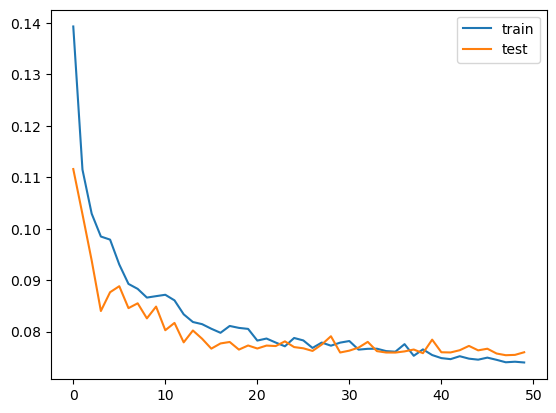

In [78]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import matplotlib.pyplot as plt


# design network
model = Sequential()

model.add(LSTM(units = 50, return_sequences=False, input_shape=[None,4]))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(np.array(X_train[3403].py()), np.array(y_train[3403].py()), 
                    epochs=50, batch_size=8, 
                    validation_data=(np.array(X_test[3403].py()), np.array(y_test[3403].py())), 
                    verbose=1, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [81]:
X_test[3403][400:]

pykx.List(pykx.q('
0f 0.26 23i 6i 0f 0.31 23i 6i 0f 0.23 23i 6i 0f 0.19 23i 6i 0f 0.24 0i  0i
0f 0.31 23i 6i 0f 0.23 23i 6i 0f 0.19 23i 6i 0f 0.24 0i  0i 0f 0.06 0i  0i
0f 0.23 23i 6i 0f 0.19 23i 6i 0f 0.24 0i  0i 0f 0.06 0i  0i 0f 0.14 0i  0i
0f 0.19 23i 6i 0f 0.24 0i  0i 0f 0.06 0i  0i 0f 0.14 0i  0i 0f 0.18 0i  0i
0f 0.24 0i 0i  0f 0.06 0i 0i  0f 0.14 0i 0i  0f 0.18 0i 0i  0f 0.17 1i 0i 
0f 0.06 0i 0i  0f 0.14 0i 0i  0f 0.18 0i 0i  0f 0.17 1i 0i  0f 0.18 1i 0i 
0f 0.14 0i 0i  0f 0.18 0i 0i  0f 0.17 1i 0i  0f 0.18 1i 0i  0f 0.23 1i 0i 
0f 0.18 0i 0i  0f 0.17 1i 0i  0f 0.18 1i 0i  0f 0.23 1i 0i  0f 0.03 1i 0i 
0f 0.17 1i 0i  0f 0.18 1i 0i  0f 0.23 1i 0i  0f 0.03 1i 0i  0f 0.13 2i 0i 
0f 0.18 1i 0i  0f 0.23 1i 0i  0f 0.03 1i 0i  0f 0.13 2i 0i  0f 0.1  2i 0i 
0f 0.23 1i 0i  0f 0.03 1i 0i  0f 0.13 2i 0i  0f 0.1  2i 0i  0f 0.11 2i 0i 
0f 0.03 1i 0i  0f 0.13 2i 0i  0f 0.1  2i 0i  0f 0.11 2i 0i  0f 0.24 2i 0i 
0f 0.13 2i 0i  0f 0.1  2i 0i  0f 0.11 2i 0i  0f 0.24 2i 0i  0f 0f   3i 0i 
0f 0.1

In [74]:
X_test[3403][60]

pykx.List(pykx.q('
0f 0.49 19i 0i
0f 0.39 19i 0i
0f 0.49 19i 0i
0f 0.28 19i 0i
0f 0.47 20i 0i
'))

3/3 [==============================] - 0s 7ms/step


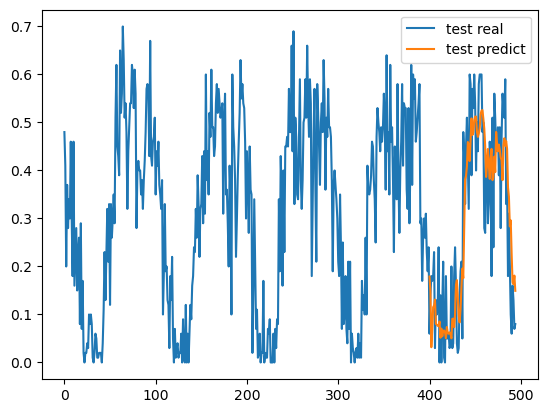

In [85]:
plt.plot(y_test[3403].py(), label='test real')
plt.plot(range(400,495), model.predict(np.array(X_test[3403][400:].py())).flatten(), label='test predict')
plt.legend()
plt.show()

# Third Iteration: Q Post

pykx.q on the other hand allows for Python code execution on a q environment and, as a result, it opens up the door for new opportunities when dealing with existing codebases as it allows for importing and using Python libraries, both installed on the system and available as .py files.



In our case we use both of these options. First, we want to execute the `haversine_vector` function to measure the distance between coordinates. Since it's not available on q, we decided to use pykx.q to incorporate this library straight into our q code with these lines:

```q
.pykx.pyexec"from haversine import haversine_vector, Unit";
```

This function expects two Pandas DataFrames as input, so we need to change the default conversion type from "np" or Numpy to "pd" or Pandas:

```q
.pykx.setdefault"pd";
```

Having done this, we can "move" our input variables to the Python memory space using `.pykx.set`

```q
.pykx.set[`a;`longitude`latitude#a];
.pykx.set[`b;`longitude`latitude#b];
```

And finally execute our function

```q
(.pykx.eval"haversine_vector(a, b, Unit.KILOMETERS, comb=True)")`
```

Notice the backtick at the end, this is for converting back to a q type.



The other way we can run Python code is to load a .py (renamed to .p) file using `\l`. This could be done as follows:

```q
system"l kerasmodel.p";
```

Here we have defined two functions named `fit` and `predict`. We can load them and use them like this:

```q
modelfit:.pykx.get`fit;
modelfit[train[0][3403];train[1][3403];test[0][3403];test[1][3403]];
modelpredict:.pykx.get`predict;
res:modelpredict[train[0][3403]];
```

---

Regarding the pure q code we migrated, the main hassle was to migrate the `time_window` function, as it relied on loops. The way we approached it was to understand the input we had, the output we needed and then think of an idiomatic way to implement it using q instead of doing a 1:1 migration, which would have probably be more costly in terms of time.



In this case, our input was a table and our output was a list of matrices for each station.



First off, regardless of whether we needed the train or test output, we needed to get either the last 80 records or up to the last 80 records. Since we needed to repeat this operation for the given columns, we decided that a functional statement would be the best fit.

```q
op:$[tt=`train;#;_];
m:`rainfall`temperature`traffic_load`hour`weekday;
data:?[data;();`traffic_station;m!({(y;(-;(count;x);80);x)}[;op]')m];
```

Once we shaped the data the way we needed, it was time to build the list of matrices. This needed to be done using a sliding window but, in order to return a **list of matrices** (not a list of tables), we needed to define two functions: one that converts a table to a matrix and another one to apply the sliding window based on a single huge matrix.

After tinkering for a while, this are the functions we came up with:

```q
toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x};
sw:{({y#z _x}[x;y;]')til count b:(y+1) _x};
```

Having done this, and after applying the proper projections, we can transform our table like so:

```q
data:(toMatrix')data;
```

And apply the sliding window function in the same way:

```q
X:(sw')data;
```

As for the y data, we created a simple `gl` (**g**et **l**oad) function that returned the traffic load data as a list with the first y+1 entries removed:

```q
gl:{(y+1) _(flip x)[2]};
```

And again applied it to our data:

```q
y:(gl')data;
```

In the end, our `time_window` function looks like this after parameterizing the train or test data we need and the look back for our sliding window:

```q
time_window:{[tt;data;lb]
    op:$[tt=`train;#;_];                                      / `train or `test decide the operator
    m:`rainfall`temperature`traffic_load`hour`weekday;        / the 5 columns we need
    data:?[data;();`traffic_station;m!({(y;(-;(count;x);80);x)}[;op]')m]; / first len-80 or last 80 depending on operator 
    sw:{({y#z _x}[x;y;]')til count b:(y+1) _x}[;lb];          / sliding window function. takes the matrix and divides into chunks of 5x5
    gl:{(y+1) _(flip x)[2]}[;lb];                             / gets the load (y data)
    toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x};    / table to matrix
    data:(toMatrix')data;                                     / convert each subtable (data is a keyed table) to a matrix
    X:(sw')data;                                              / apply sliding window to get X
    y:(gl')data;                                              / and gl to get y
    (X;y)                                                     / return both
    };
```

Which we can use like so:

```q
train:time_window[`train;final;5];
```

In the end, returns a list of dictionaries. The first element is the X and the second one is the y. Both of them contain registries for all stations, which can be indexed like you would on a dictionary, so for accessing the X data for the station with id 3403 you would do it with:

```q
train[0][3403]
```

This fits exactly with what we need to feed into our `fit` and `predict` functions, so no further conversions are needed


``` python
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D

model = Sequential()
model.add(LSTM(units = 500, return_sequences=True, input_shape=[None,5]))
model.add(LSTM(units = 250,return_sequences=True))
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
model.summary()

def fit(train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y, epochs=3, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    return True


def predict(data):
    return model.predict(data)

```